# Download Earthquake Data

In [16]:
from obspy.clients.fdsn import Client
import time
from obspy import read_events, read, Stream, read_inventory, UTCDateTime
from obspy.geodetics.base import locations2degrees, gps2dist_azimuth
from obspy.taup import TauPyModel #velocity model to compute the arrivals time for p waves.....
from obspy.core import AttribDict #to insert the headers into SAC files like stationlat,lon, eqrthquake lat,lon, magnitude..
import os
import http.client
import matplotlib.pyplot as plt
import numpy as np

The details about [obspy.clients.fdsn](https://docs.obspy.org/packages/obspy.clients.fdsn.html).

In [17]:
sta='AAK'
staxml = read_inventory("../staxml/"+str(sta)+".xml") # reads the station xml file, for this first you need to import station xml file from other program named 01-get_xml.ipynb
station_lat = staxml[0][0].latitude # give station latitude, station_lat is the variable defined by you
station_lon = staxml[0][0].longitude
network_code=staxml[0].code
print(station_lat,station_lon, network_code) # prints station lat lon network

42.6375 74.4942 II


The [key string](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.html) for recognized server is one of ‘AUSPASS’, ‘BGR’, ‘EMSC’, ‘ETH’, ‘GEOFON’, ‘GEONET’, ‘GFZ’,‘ICGC’,
‘IESDMC’, ‘INGV’, ‘IPGP’, ‘IRIS’,‘IRISPH5’, ‘ISC’, ‘KNMI’, ‘KOERI’, ‘LMU’, ‘NCEDC’,‘NIEP’, ‘NOA’, ‘ODC’, ‘ORFEUS’,
‘RASPISHAKE’, ‘RESIF’,‘RESIFPH5’, ‘SCEDC’, ‘TEXNET’, ‘UIB-NORSAR’, ‘USGS’, ‘USP’.

In [18]:
model = TauPyModel(model="ak135") # define earthmodel "ak135" from which we compute p-wave trave time
eventClient = Client("IRIS") # define client for the station you are interested
t1 = UTCDateTime("2023-02-06T00:00:00") # interested start time for dowloading earthquake
t2 = UTCDateTime("2023-02-07T23:59:59") # end time for the waveform you want to download
#  cat = eventClient.get_events(starttime=t1, endtime=t2, minmagnitude=7.5,latitude=station_lat,
#                              longitude=station_lon,minradius=30,maxradius=95,catalog="GCMT")
cat = eventClient.get_events(starttime=t1, endtime=t2, minmagnitude=7.5,latitude=station_lat,
                             longitude=station_lon,catalog="GCMT") # provides the catalog of the events within time t1 to t2 with magnitude greater than 7.5
print(cat) # prints the catalog of event 

# cat.write(catpath+'catalog.xml',format="QUAKEML")


2 Event(s) in Catalog:
2023-02-06T10:24:59.000000Z | +38.110,  +37.220 | 7.7 MW
2023-02-06T01:18:10.400000Z | +37.560,  +37.470 | 7.8 MW


information about [get_events](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_events.html)

In [19]:
client = Client("IRIS")
event=cat[1]  ##take only second event from the list of catalogue i.e., 7.8 magnitude earthquake
event_lat = event.origins[0].latitude # get latitude of the event
event_lon = event.origins[0].longitude # get longitude of the event
event_depth = event.origins[0].depth # get depth of the event
event_mag = event.magnitudes[0].mag # get magnitude of the event
event_time = event.origins[0].time
event_date=event_time.date
event_hr=event_time.time.hour
event_min=event_time.time.minute
event_sec=event_time.time.second
event_id=str(event_date)+"T"+str(event_hr)+"."+str(event_min)+"."+str(event_sec) # provide the name to the sac file of the event

deg = locations2degrees(event_lat, event_lon, station_lat, station_lon) # to get great circle distance between source and station
# print(event_date)

# [Arrivals](https://docs.obspy.org/packages/obspy.taup.html)

In [20]:
##     all_arrivals=model.get_travel_times(source_depth_in_km=55,distance_in_degree=67)
##     print(all_arrivals)

###consider specific arrivals only, parameters required for computing the arrival times of P, pP, S waves using the model "ak135"
arrivals = model.get_travel_times(source_depth_in_km=event_depth/1000,
                                      distance_in_degree=deg,phase_list=["P","pP","S"])
## arrivals = model.get_travel_times(source_depth_in_km=event_depth/1000,
##                                       distance_in_degree=deg)
print(arrivals) # prints the list of arrival times

p_phase = arrivals[0].time
pP_phase=arrivals[1].time 
s_phase=arrivals[2].time
print('P arrival time=',p_phase,'pP arrival time=',pP_phase,'S arrival time=',s_phase)

3 arrivals
	P phase arrival at 355.027 seconds
	pP phase arrival at 359.575 seconds
	S phase arrival at 642.396 seconds
P arrival time= 355.027055488 pP arrival time= 359.575418927 S arrival time= 642.396028178


# [Get Waveform](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_waveforms.html)

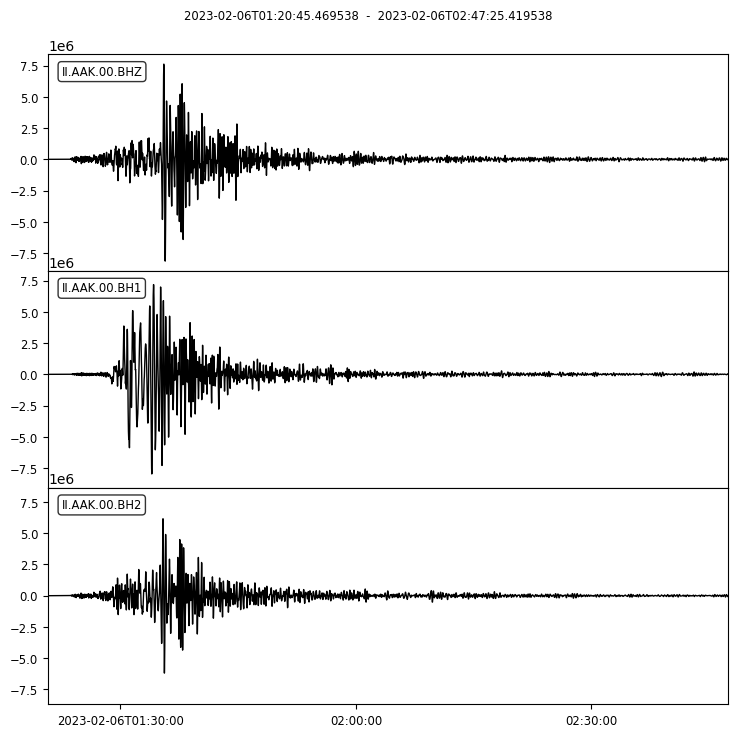

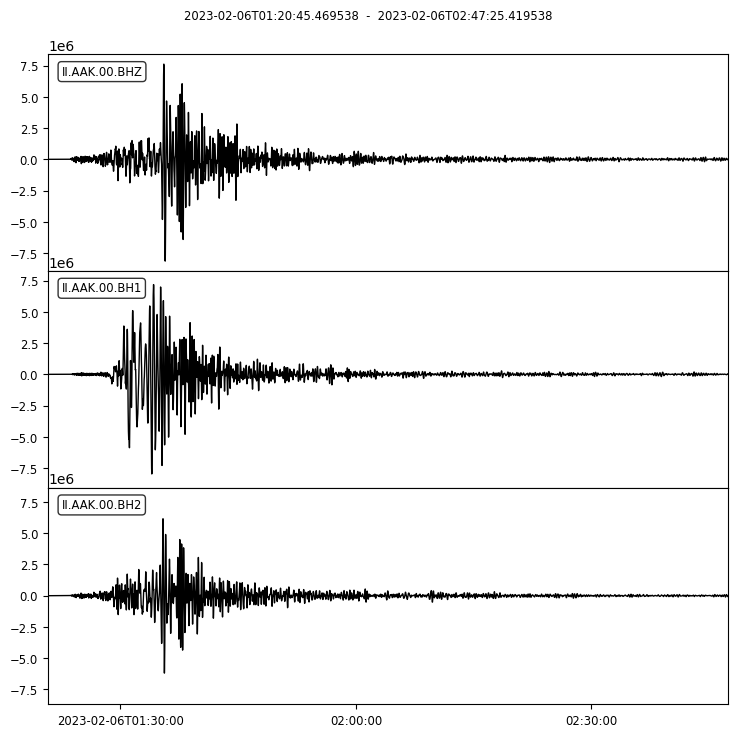

In [21]:
st = client.get_waveforms(network_code, sta,'00','BH*', starttime=event_time+p_phase-200, endtime=event_time+p_phase+5000,
                          attach_response=True) # to get the waveforms for the interested event 200 sec before the arrival of p phase and 5000 sec after the arrival of p-phase with network code "II", station name "AAK"
st.plot() # plots the waveform

# Visualize waveform

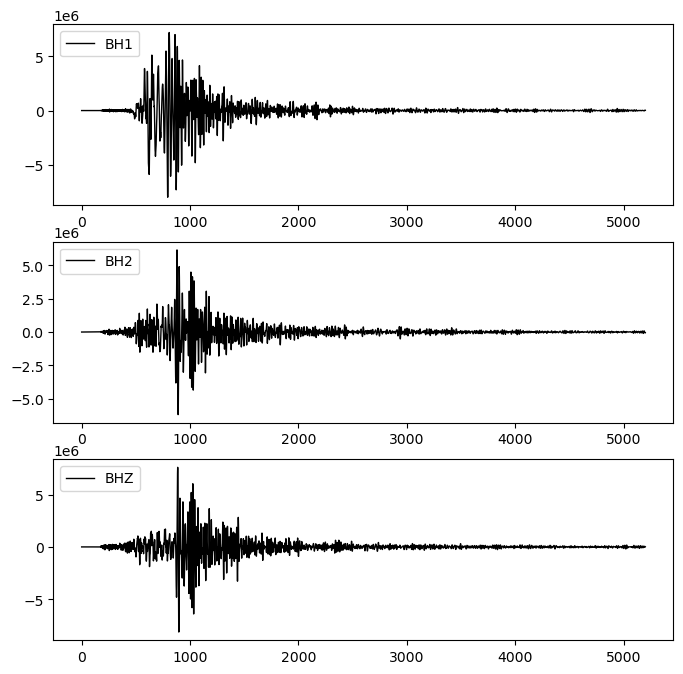

In [22]:
plt.figure(figsize=(8,8))
for i,tr in enumerate(st):
    j=i+1
    time=np.arange(tr.stats.npts)*tr.stats.delta
    channel=tr.stats.channel
    plt.subplot(int(str(31)+str(j)))
    plt.plot(time,tr.data,color='black',linewidth=1,label=str(channel))
    plt.legend(loc=2)
#     plt.xlim(0,60)
plt.show()

### Adding information in waveform data

In [24]:
# to store the information about station, event, magnitude on sac file that you have downloaded
sacd=AttribDict()
sacd.evla = event_lat # stores the event latitude
sacd.evlo = event_lon
sacd.evdp  = event_depth/1000.
sacd.stla  = station_lat
sacd.stlo  = station_lon
sacd.mag   = event_mag
sacd.t0= p_phase
# sacd.t1= pP_phase
# sacd.t2= s_phase
os.mkdir("../earthquake_raw_data/"+str(sta)) #to make a folder with name of station file(here, AAK) inside earthquake_raw_data, Here you store your sac file (waveforms) (NOTE: run this command once and comment it out as folder already exists if you run it for second time)
for tr in st:
    tr.stats.sac=sacd
    tr.write("../earthquake_raw_data/"+str(sta)+"/"+event_id+'_'+tr.stats.station+'_'+tr.stats.channel+'.SAC',
             format='SAC') # write the waveforms in the folder defined above
    


In [25]:
tr= read("../earthquake_raw_data/"+str(sta)+"/2023-02-06T1.18.10_AAK_BHZ.SAC")[0] # how to read the sac file that you have saved earlier 
depth=tr.stats.sac.evdp #drag the information on depth of the event
print(depth) # print the value of depth

14.9


In [39]:
# print(tr.stats.sac)
# st.plot()